# Boilerplate and Variables

In [1]:
import pickle
import afidutils
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests
from scipy.stats import wilcoxon, uniform, randint
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV,GroupKFold 
from sklearn.utils import check_random_state
from sklearn.model_selection._split import _RepeatedSplits


#To make plots look sharper
%config InlineBackend.figure_format = 'retina'

# Used for filtering AFIDs
exclude_afids = ['CULx','PGx','GENUx', 'SPLEx', 'ALTHx', 'SAMTHx', 'IAMTHx', 'IGOx','VOHx','OSFx',
                 'CULy','PGy','GENUy', 'SPLEy', 'ALTHy', 'SAMTHy', 'IAMTHy', 'IGOy','VOHy','OSFy',
                 'CULz','PGz','GENUz', 'SPLEz', 'ALTHz', 'SAMTHz', 'IAMTHz', 'IGOz','VOHz','OSFz'
                ]

# Train Data Subject IDs
train_subids = pd.read_csv("/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/train_data.csv")
# Test Data Subject IDs - only used for exclusion
test_subids = pd.read_csv("/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/test_data.csv")

# Data Split

In [2]:
# Paths
base_path = '/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate'
stn_path = f'{base_path}/STN'
afids_path = f'{base_path}/AFIDs'

# Get list of STN coordinate files (MCP-aligned)
stn_fcsv = sorted(glob(f'{stn_path}/*/stn_mcp/*/*/*MCP*.fcsv'))

# Load and concatenate STN data
df_stn = pd.concat([afidutils.fcsvtodf(s)[0] for s in stn_fcsv], axis=0)
df_stn.columns = ['RSTNx', 'LSTNx', 'RSTNy', 'LSTNy', 'RSTNz', 'LSTNz']

# Mirror left STN x-coordinates
df_stn['LSTNx'] *= -1

# Create left/right STN DataFrames with common labels
df_stn_r = df_stn[['RSTNx', 'RSTNy', 'RSTNz']].rename(columns=lambda c: c[1:])
df_stn_l = df_stn[['LSTNx', 'LSTNy', 'LSTNz']].rename(columns=lambda c: c[1:])
df_stn_proc = pd.concat([df_stn_r, df_stn_l], axis=0)

# Load subject-level AFIDs and concatenate
afids_fcsv = sorted(glob(f'{afids_path}/*/afids_mcp/*/*/*MCP*.fcsv'))

df_subs_afids = pd.concat([afidutils.fcsvtodf(f)[0] for f in afids_fcsv], axis=0)

df_afids_proc = afidutils.flip_and_concatenate_hemispheres(df_subs_afids)

# Select other data (i.e., subs with no STN labels)
df_afids_proc_other = df_afids_proc.drop(index=test_subids['subjid'].to_list())
df_afids_proc_other = df_afids_proc_other.drop(index=train_subids['subjid'].to_list())

# Select training data
df_afids_proc_train = df_afids_proc.loc[train_subids['subjid'].to_list()]
df_stn_proc_train = df_stn_proc.loc[train_subids['subjid'].to_list()]

# Select testing data
valid_ids = [i for i in test_subids['subjid'].to_list() if i in df_stn_proc.index]
df_stn_proc_test = df_stn_proc.loc[valid_ids]
df_afids_proc_test = df_afids_proc.loc[valid_ids]


# Create np. arrays
df_afids_proc_other = df_afids_proc_other.to_numpy()
df_afids_proc_train = df_afids_proc_train.to_numpy()
df_afids_proc_test = df_afids_proc_test.to_numpy()
df_stn_proc_test = df_stn_proc_test.to_numpy()
df_stn_proc_train = df_stn_proc_train.to_numpy()

In [3]:
print("\n====== Dataset Summary ======")
print(f"📂 Total STN files loaded:                  {len(stn_fcsv)}")
print(f"📂 Total AFID files loaded:                 {len(afids_fcsv)}")

print(f"\n🧠 STN Data:")
print(f"  - Raw STN DataFrame shape:                {df_stn.shape}")
print(f"  - Processed STN (mirrored) shape:         {df_stn_proc.shape}")

print(f"\n📌 AFIDs Data:")
print(f"  - Raw AFIDs DataFrame shape:              {df_subs_afids.shape}")
print(f"  - Processed AFIDs (mirrored) shape:       {df_afids_proc.shape}")

print(f"\n📊 Subset Breakdown:")
print(f"  - Train data AFIDs shape:                   {df_afids_proc_train.shape}")
print(f"  - Train data STN shape:                     {df_stn_proc_train.shape}")
print(f"  - Test data AFIDs shape:                   {df_afids_proc_test.shape}")
print(f"  - Test data STN shape:                     {df_stn_proc_test.shape}")
print(f"  - Remaining (non-train/test) AFIDs shape: {df_afids_proc_other.shape}")
print("================================\n")


====== Dataset Summary ======
📂 Total STN files loaded:                  70
📂 Total AFID files loaded:                 202

🧠 STN Data:
  - Raw STN DataFrame shape:                (70, 6)
  - Processed STN (mirrored) shape:         (140, 3)

📌 AFIDs Data:
  - Raw AFIDs DataFrame shape:              (202, 96)
  - Processed AFIDs (mirrored) shape:       (404, 33)

📊 Subset Breakdown:
  - Train data AFIDs shape:                   (100, 33)
  - Train data STN shape:                     (100, 3)
  - Test data AFIDs shape:                   (40, 33)
  - Test data STN shape:                     (40, 3)
  - Remaining (non-train/test) AFIDs shape: (224, 33)



# ML

## Ridge Regression

In [4]:
# Define hyperparameters
alphas = np.logspace(-100, 100, 10000)  # Very wide range for RidgeCV tuning
k = 4                                   # Number of outer CV folds
var = 0.99                             # % variance to retain in PCA

# Group sides together 
result_list = afidutils.create_list(df_afids_proc_train.shape[0]//2) #grouping left and right labels

# Initialize K-fold cross-validation
kf = GroupKFold(n_splits=k)
best_alpha_values = []

# === Outer loop: GroupKFold ===
for n, (train_index, test_index) in enumerate(kf.split(df_afids_proc_train, groups=result_list)):
    # Split training and testing data for this fold
    X_train, X_test = df_afids_proc_train[train_index], df_afids_proc_train[test_index]
    y_train, y_test = df_stn_proc_train[train_index], df_stn_proc_train[test_index]

    # Keep group labels for tracking
    results_list_inner = [result_list[i] for i in train_index]

    # === Preprocessing ===
    # Concatenate external training data (e.g., from other subjects) for more stable PCA
    X_train_c = np.concatenate((X_train, df_afids_proc_other), axis=0)

    # Fit scaler and PCA on the augmented training data
    scaler = StandardScaler()
    pca = PCA(n_components=var)

    X_train_scaled_c = scaler.fit_transform(X_train_c)
    pca.fit(X_train_scaled_c)  # Fit PCA on scaled augmented data

    # Transform train/test data using fitted scaler and PCA
    X_train_pca = pca.transform(scaler.transform(X_train))
    X_test_pca  = pca.transform(scaler.transform(X_test))

    # === Inner loop: RidgeCV ===
    inner_cv = list(GroupKFold(n_splits=3).split(X_train_pca, groups=results_list_inner))
    ridge_cv = RidgeCV(fit_intercept=False, alphas=alphas, scoring='neg_mean_squared_error', cv=inner_cv)
    model_cv = MultiOutputRegressor(ridge_cv, n_jobs=-1)
    model_cv.fit(X_train_pca, y_train)

    # Extract best alphas from trained RidgeCV models (1 per target dimension)
    best_alphas = [est.alpha_ for est in model_cv.estimators_]
    best_alpha_values.append(best_alphas)

    # Train final Ridge models for this fold using best alphas
    ridge_estimators = [
        Ridge(alpha=alpha).fit(X_train_pca, y_train[:, i])
        for i, alpha in enumerate(best_alphas)
    ]

    # Predict and evaluate on the test set
    y_pred = np.column_stack([ridge.predict(X_test_pca) for ridge in ridge_estimators])
    mse_x = (y_test[:, 0] - y_pred[:, 0]) ** 2
    mse_y = (y_test[:, 1] - y_pred[:, 1]) ** 2
    mse_z = (y_test[:, 2] - y_pred[:, 2]) ** 2
    ED = np.sqrt(mse_x + mse_y + mse_z)

    # Report results
    print(f"Fold-{n+1}")
    print(f"ED combined: {ED.mean():.2f} ± {ED.std():.2f}")
    print(f"mse_x: {mse_x.mean():.2f} ± {mse_x.std():.2f}")
    print(f"mse_y: {mse_y.mean():.2f} ± {mse_y.std():.2f}")
    print(f"mse_z: {mse_z.mean():.2f} ± {mse_z.std():.2f}")
    print()

# === Alpha summary ===
alpha_paper = pd.DataFrame(
    np.array(best_alpha_values),
    columns=["x", "y", "z"],
    index=[f"fold {i+1}" for i in range(k)]
)
alpha_mean = alpha_paper.mean(axis=0)

print("Best alpha values per fold:")
print(alpha_paper)
print("\nAverage alpha values:")
print(alpha_mean)

Fold-1
ED combined: 0.90 ± 0.43
mse_x: 0.38 ± 0.66
mse_y: 0.42 ± 0.51
mse_z: 0.19 ± 0.33

Fold-2
ED combined: 0.94 ± 0.34
mse_x: 0.35 ± 0.50
mse_y: 0.41 ± 0.53
mse_z: 0.25 ± 0.23

Fold-3
ED combined: 0.85 ± 0.40
mse_x: 0.26 ± 0.39
mse_y: 0.34 ± 0.42
mse_z: 0.28 ± 0.35

Fold-4
ED combined: 0.82 ± 0.50
mse_x: 0.30 ± 0.81
mse_y: 0.41 ± 0.66
mse_z: 0.22 ± 0.25

Best alpha values per fold:
                x         y          z
fold 1  16.222621  7.080844  14.129117
fold 2  19.504239  3.090644  16.987247
fold 3   6.167072  1.778382   5.129452
fold 4   4.467505  6.457747   3.548583

Average alpha values:
x    11.590359
y     4.601904
z     9.948600
dtype: float64


## XGBoost

In [5]:
# Define hyperparameters
k = 4                                   # Number of outer CV folds
n_iter_search = 1000                     # Number of random search iterations

# Define hyperparameter space for XGBoost
xgb_param_dist = {
    'n_estimators': randint(50, 500),                 # boosting rounds
    'max_depth': randint(2, 12),                      # model complexity
    'learning_rate': uniform(0.01, 0.3),              # shrinkage
    'subsample': uniform(0.6, 0.4),                   # row sampling
    'colsample_bytree': uniform(0.6, 0.4),            # feature sampling
    'gamma': uniform(0, 5),                           # min split loss
    'reg_alpha': uniform(0, 1),                       # L1 regularization
    'reg_lambda': uniform(0, 2),                      # L2 regularization
}

# Group sides together
result_list = afidutils.create_list(df_afids_proc_train.shape[0] // 2)

# Outer CV
kf = GroupKFold(n_splits=k)
best_param_values = []

# === Outer loop ===
for n, (train_index, test_index) in enumerate(kf.split(df_afids_proc_train, groups=result_list)):
    X_train, X_test = df_afids_proc_train[train_index], df_afids_proc_train[test_index]
    y_train, y_test = df_stn_proc_train[train_index], df_stn_proc_train[test_index]

    results_list_inner = [result_list[i] for i in train_index]

    # === Inner CV: RandomizedSearchCV on XGBoost ===
    inner_cv = list(GroupKFold(n_splits=3).split(X_train, groups=results_list_inner))
    
    xgb_base = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42, verbosity=0)
    model_cv = MultiOutputRegressor(
        RandomizedSearchCV(
            xgb_base,
            param_distributions=xgb_param_dist,
            n_iter=n_iter_search,
            scoring='neg_mean_squared_error',
            cv=inner_cv,
            random_state=42,
            n_jobs=-1
        )
    )
    model_cv.fit(X_train, y_train)

    # Extract best parameters for each output regressor
    best_params = [est.best_params_ for est in model_cv.estimators_]
    best_param_values.append(best_params)

    # Train final XGB models for this fold using best parameters
    xgb_estimators = [
        XGBRegressor(**params, objective='reg:squarederror', n_jobs=-1).fit(X_train, y_train[:, i])
        for i, params in enumerate(best_params)
    ]

    # Predict and evaluate
    y_pred = np.column_stack([xgb.predict(X_test) for xgb in xgb_estimators])
    mse_x = (y_test[:, 0] - y_pred[:, 0]) ** 2
    mse_y = (y_test[:, 1] - y_pred[:, 1]) ** 2
    mse_z = (y_test[:, 2] - y_pred[:, 2]) ** 2
    ED = np.sqrt(mse_x + mse_y + mse_z)

    print(f"Fold-{n+1}")
    print(f"ED combined: {ED.mean():.2f} ± {ED.std():.2f}")
    print(f"mse_x: {mse_x.mean():.2f} ± {mse_x.std():.2f}")
    print(f"mse_y: {mse_y.mean():.2f} ± {mse_y.std():.2f}")
    print(f"mse_z: {mse_z.mean():.2f} ± {mse_z.std():.2f}")
    print()

# === Param Summary ===
# Convert list-of-list-of-dict to summary table
def summarize_params(param_list, target_names=['x', 'y', 'z']):
    df_list = []
    for fold_params in param_list:
        df_fold = pd.DataFrame(fold_params, index=target_names)
        df_list.append(df_fold)
    return pd.concat(df_list, keys=[f"fold {i+1}" for i in range(len(df_list))])

param_df = summarize_params(best_param_values)
param_summary = param_df.groupby(level=1).agg(lambda x: pd.Series.mode(x)[0])

print("Best hyperparameters per fold:")
print(param_df)
print("\nMost common (mode) hyperparameters per target:")
print(param_summary)


Fold-1
ED combined: 1.01 ± 0.43
mse_x: 0.35 ± 0.50
mse_y: 0.62 ± 0.70
mse_z: 0.24 ± 0.37

Fold-2
ED combined: 1.06 ± 0.36
mse_x: 0.43 ± 0.53
mse_y: 0.54 ± 0.76
mse_z: 0.28 ± 0.26

Fold-3
ED combined: 0.82 ± 0.36
mse_x: 0.17 ± 0.23
mse_y: 0.33 ± 0.39
mse_z: 0.31 ± 0.49

Fold-4
ED combined: 0.95 ± 0.51
mse_x: 0.34 ± 0.79
mse_y: 0.61 ± 0.87
mse_z: 0.21 ± 0.23

Best hyperparameters per fold:
          colsample_bytree     gamma  learning_rate  max_depth  n_estimators  \
fold 1 x          0.794007  0.427015       0.301738          9           119   
       y          0.954647  0.138084       0.183659          8           496   
       z          0.715274  0.032322       0.158872         10            87   
fold 2 x          0.901438  1.018336       0.108266          7           434   
       y          0.945516  2.033869       0.238708          9           260   
       z          0.807360  0.563046       0.290196          6           424   
fold 3 x          0.874531  0.348206       0.0624

## ML Model Comparison 

In [6]:
class RepeatedGroupKFold(_RepeatedSplits):
    """Repeated Group K-Fold cross validator.
    Repeats Group K-Fold n times with different randomization in each repetition.
    Read more in the :ref:`User Guide <repeated_group_k_fold>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    n_repeats : int, default=10
        Number of times cross-validator needs to be repeated.
    random_state : int, RandomState instance or None, default=None
        Controls the randomness of each repeated cross-validation instance.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    """
    def __init__(self, *, n_splits=5, n_repeats=10, random_state=None):
        super().__init__(
            GroupKFold, n_repeats=n_repeats,
            random_state=random_state, n_splits=n_splits)
        
    def split(self, X, y=None, groups=None):
        """Generates indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            The target variable for supervised learning problems.
        groups : array-like of shape (n_samples,), default=None
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        n_repeats = self.n_repeats
        rng = check_random_state(self.random_state)

        for idx in range(n_repeats):
            cv = self.cv(random_state=rng, shuffle=True,
                            **self.cvargs)
            for train_index, test_index in cv.split(X, y, groups):
                yield train_index, test_index


In [7]:
def clean_params(params):
    params = params.copy()
    
    # Ensure integer hyperparameters
    if 'n_estimators' in params:
        params['n_estimators'] = int(params['n_estimators'])
    if 'max_depth' in params:
        params['max_depth'] = int(params['max_depth'])

    # Ensure float-type hyperparameters
    for key in ['learning_rate', 'subsample', 'colsample_bytree',
                'gamma', 'reg_alpha', 'reg_lambda']:
        if key in params:
            params[key] = float(params[key])

    return params

In [8]:
def evaluate_model_repeated_cv(
    model_name,
    X,
    y,
    groups,
    fixed_params,
    n_splits=4,
    n_repeats=10,
    pca_variance=0.99,
    random_state=42):
    """
    Evaluate Ridge or XGBoost using RepeatedGroupKFold with fixed hyperparameters.
    Returns a DataFrame with ED and MSE metrics for each fold.
    """
    rkf = RepeatedGroupKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    results = []

    for fold_idx, (train_idx, test_idx) in enumerate(tqdm(rkf.split(X, y, groups=groups), total=n_splits * n_repeats)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # === Preprocessing ===
        if model_name == "ridge":
            # Standardize and apply PCA
            scaler = StandardScaler()
            pca = PCA(n_components=pca_variance)
            
            X_train_c = np.concatenate((X_train, df_afids_proc_other), axis=0)


            x = scaler.fit_transform(X_train_c)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            pca.fit(x)
            X_train_proc = pca.transform(X_train_scaled)
            X_test_proc = pca.transform(X_test_scaled)

            # Train Ridge per target using fixed alphas
            ridge_models = [
                Ridge(alpha=alpha).fit(X_train_proc, y_train[:, i])
                for i, alpha in enumerate(fixed_params)
            ]
            y_pred = np.column_stack([ridge.predict(X_test_proc) for ridge in ridge_models])

        elif model_name == "xgb":
            # No scaling or PCA for XGBoost
            xgb_models = [
                XGBRegressor(**fixed_params[i], objective='reg:squarederror', n_jobs=-1)
                .fit(X_train, y_train[:, i])
                for i in range(3)
            ]
            y_pred = np.column_stack([xgb.predict(X_test) for xgb in xgb_models])

        else:
            raise ValueError("model_name must be 'ridge' or 'xgb'")

        # === Metrics ===
        mse_x = ((y_test[:, 0] - y_pred[:, 0]) ** 2).mean()
        mse_y = ((y_test[:, 1] - y_pred[:, 1]) ** 2).mean()
        mse_z = ((y_test[:, 2] - y_pred[:, 2]) ** 2).mean()
        ed = np.sqrt(((y_test - y_pred) ** 2).sum(axis=1)).mean()

        results.append({
            "model": model_name,
            "fold": fold_idx + 1,
            "mse_x": mse_x,
            "mse_y": mse_y,
            "mse_z": mse_z,
            "ED": ed
        })

    return pd.DataFrame(results)

ridge_results = evaluate_model_repeated_cv(
    model_name="ridge",
    X=df_afids_proc_train,
    y=df_stn_proc_train,
    groups=result_list,
    fixed_params=alpha_mean.values  # array([alpha_x, alpha_y, alpha_z])
)

xgb_results = evaluate_model_repeated_cv(
    model_name="xgb",
    X=df_afids_proc_train,
    y=df_stn_proc_train,
    groups=result_list,
    fixed_params=[clean_params(param_summary.loc[dim].to_dict()) for dim in ['x', 'y', 'z']]
)

100%|██████████| 40/40 [00:21<00:00,  1.86it/s]


In [9]:
def compare_models_stats(ridge_df, xgb_df, correction="bonferroni"):
    metrics = ["mse_x", "mse_y", "mse_z", "ED"]
    results = []

    for metric in metrics:
        ridge_scores = ridge_df[metric].values
        xgb_scores = xgb_df[metric].values
        diff = np.round(ridge_scores - xgb_scores,3)
        stat, p = wilcoxon(diff)
        test_name = "Wilcoxon"

        results.append({
            "metric": metric,
            "test": test_name,
            "statistic": stat,
            "p_uncorrected": p
        })

    # Correction for multiple comparisons
    p_vals = [r["p_uncorrected"] for r in results]
    reject, p_corrected, _, _ = multipletests(p_vals, method=correction)

    for i, r in enumerate(results):
        r["p_corrected"] = p_corrected[i]
        r["significant"] = reject[i]

    return pd.DataFrame(results)

# Wilcoxon + Bonferroni (default)
compare_models_stats(ridge_results, xgb_results)


,metric,test,statistic,p_uncorrected,p_corrected,significant
0,mse_x,Wilcoxon,197.5,4.284251e-03,0.017137,True
1,mse_y,Wilcoxon,31.0,3.491659e-07,0.000001,True
2,mse_z,Wilcoxon,291.0,1.096663e-01,0.438665,False
3,ED,Wilcoxon,129.0,1.586443e-04,0.000635,True


In [10]:
def plot_model_comparisons(ridge_df, xgb_df):
    metrics = ["mse_x", "mse_y", "mse_z", "ED"]
    combined = []

    for metric in metrics:
        for model_name, df in zip(["Ridge", "XGBoost"], [ridge_df, xgb_df]):
            for val in df[metric].values:
                combined.append({"model": model_name, "metric": metric, "value": val})

    plot_df = pd.DataFrame(combined)

    # Plot
    sns.set(style="white", font_scale=1.1)
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(
        data=plot_df, x="metric", y="value", hue="model",
        inner="box", split=True, palette="muted"
    )

    # Statistical annotation
    pairs = [
        (("mse_x", "Ridge"), ("mse_x", "XGBoost")),
        (("mse_y", "Ridge"), ("mse_y", "XGBoost")),
        (("mse_z", "Ridge"), ("mse_z", "XGBoost")),
        (("ED", "Ridge"), ("ED", "XGBoost")),
    ]

    annotator = Annotator(ax, pairs, data=plot_df, x="metric", y="value", hue="model")
    annotator.configure(test="Wilcoxon", text_format="star", loc="inside", comparisons_correction="bonferroni")
    annotator.apply_and_annotate()

    plt.ylabel("Error (mm)")
    plt.xlabel("Metric")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.savefig("/Users/alaataha/Documents/GitHub/afids-pred/figures/ridge_vs_xgb.png")
    plt.show()


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mse_y_Ridge vs. mse_y_XGBoost: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.728e-08 Stat=3.100e+01
mse_x_Ridge vs. mse_x_XGBoost: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.408e-02 Stat=1.970e+02
mse_z_Ridge vs. mse_z_XGBoost: Wilcoxon test (paired samples) with Bonferroni correction, P_val:4.599e-01 Stat=2.920e+02
ED_Ridge vs. ED_XGBoost: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.687e-04 Stat=1.280e+02


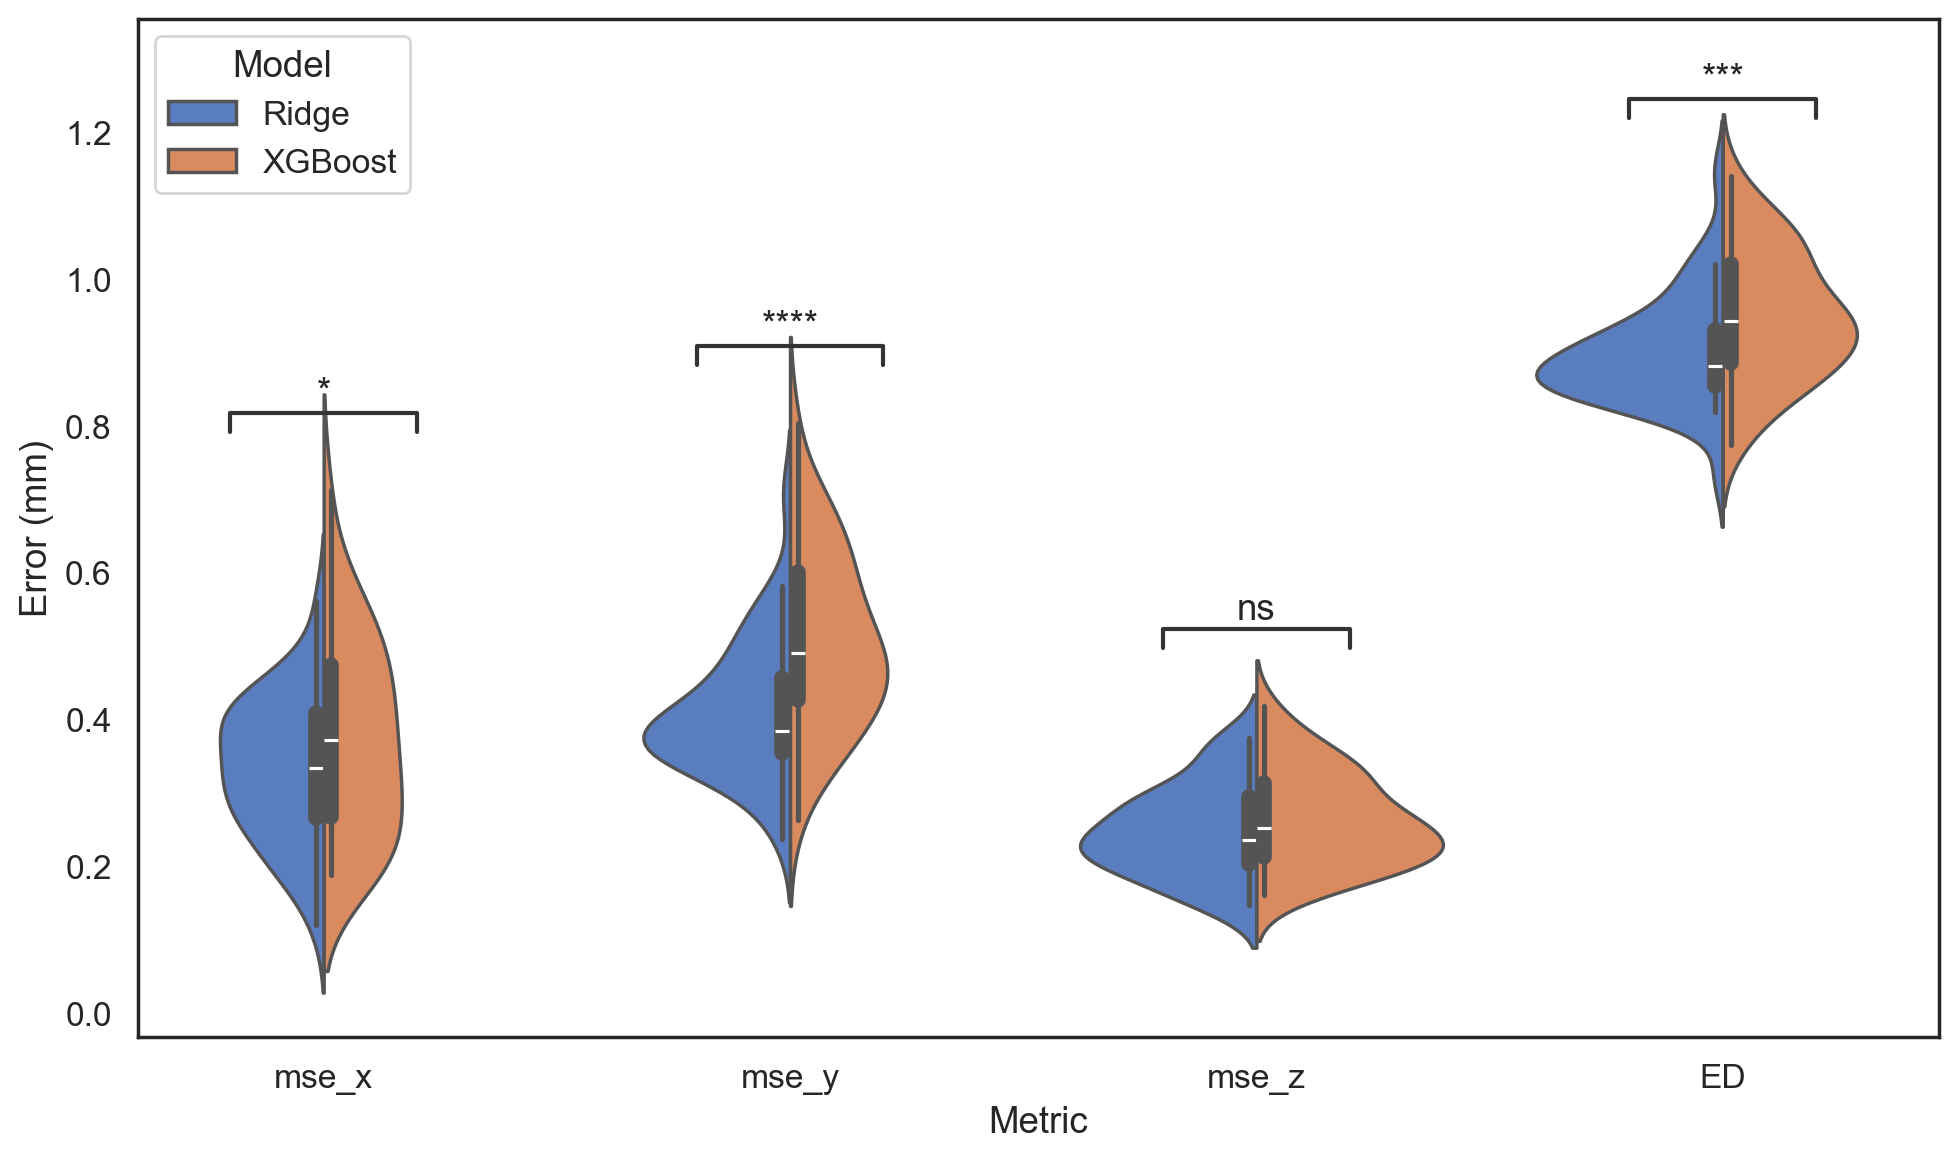

In [11]:
plot_model_comparisons(ridge_results, xgb_results)


## Training Best Model

In [12]:
# === Final model training on full dataset ===
# Combine full training + external data
X_train_full = np.concatenate((df_afids_proc_train, df_afids_proc_other), axis=0)

# Fit scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components=var)
X_train_scaled_f = scaler.fit_transform(X_train_full)
X_train_pca_f = pca.fit_transform(X_train_scaled_f)

# Transform training data (no test data here)
X_train_scaled = scaler.transform(df_afids_proc_train)
X_train_pca = pca.transform(X_train_scaled)

# Train final Ridge models using average alpha values
ridge_final = [
    Ridge(alpha=alpha).fit(X_train_pca, df_stn_proc_train[:, i])
    for i, alpha in enumerate(alpha_mean)
]

# Save entire pipeline as a dictionary (for reproducibility)
model_dict = {
    'standard_scaler': scaler,
    'pca': pca,
    'x': ridge_final[0],
    'y': ridge_final[1],
    'z': ridge_final[2]
}

with open('/Users/alaataha/Documents/GitHub/afids-pred/resources/afids_stn_model_all_data.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

print("\nFinal model and pipeline saved to 'afids_stn_model_all_data.pkl'")


Final model and pipeline saved to 'afids_stn_model_all_data.pkl'
